In [1]:
import pandas as pd
import numpy as np
    
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, pearsonr, zscore
from scipy.spatial.distance import squareform
from statsmodels.stats.multitest import multipletests
#! pip install nibabel
import nibabel as nib
import scipy.io
import os
import pandas as pd
from scipy.interpolate import interp1d
from scipy import stats
import sys
from sklearn.preprocessing import MinMaxScaler
from matplotlib.backends.backend_pdf import PdfPages

file_path = os.getcwd()
file_path = file_path.split('/')
root_path = '/'.join(file_path[:-2]) + '/'
# root_path='/home/dayoung/dFC/RL'

sys.path.append(os.path.join(root_path, "tools"))
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
#import mat73

from isc_standalone import isc, isfc

/home/dayoung/anaconda3/envs/bandits/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/dayoung/anaconda3/envs/bandits/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


(231, 147, 54)


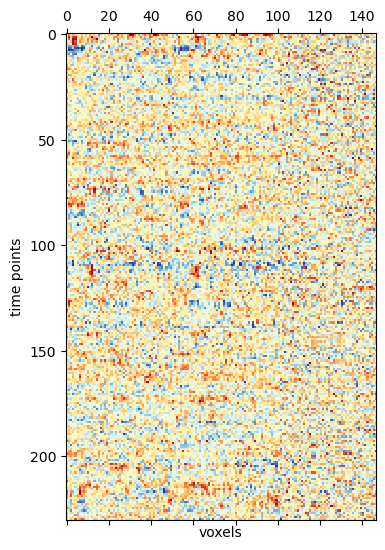

In [2]:
neuro_data_whole = scipy.io.loadmat(os.path.join(root_path, "data", "ts_all.mat"))
beh_data_whole = scipy.io.loadmat(os.path.join(root_path, "data", "behav", "signal_data.mat"))
Nsubj = 54
TR = 1.5

ts_all = neuro_data_whole['ts_all_' + str(Nsubj) + 'sub']
tp = int(np.shape(ts_all)[0]/Nsubj)
Nnodes = np.shape(ts_all)[1]
neuro_data = np.zeros([Nsubj, tp, Nnodes])
for si in range(Nsubj):
    tmp_ts = ts_all[0 + si*tp : tp + si*tp]
    neuro_data[si] = tmp_ts

# Create a simple visualization of the data
plt.matshow(neuro_data[0], cmap='RdYlBu_r', vmin=-3, vmax=3)
plt.grid(False)
plt.xlabel('voxels')
plt.ylabel('time points')
neuro_data = np.moveaxis(neuro_data, 0, 2)
print(np.shape(neuro_data))

In [3]:
signal_labels = list(beh_data_whole.keys())[3:]
signal_hrf_labels = [x for x in signal_labels if x[-4:] == '_hrf']
signal_labels = [x for x in signal_labels if x[-4:] != '_hrf']
print(signal_hrf_labels)
print(len(signal_hrf_labels))
print(signal_labels)
print(len(signal_labels))

for ii in range(len(signal_hrf_labels)):
    globals()[signal_hrf_labels[ii]] = beh_data_whole[signal_hrf_labels[ii]]
    if ii == 0:
        behav_hrf_data = globals()[signal_hrf_labels[ii]]
    else:
        behav_hrf_data = np.dstack([behav_hrf_data, globals()[signal_hrf_labels[ii]]])

for ii in range(len(signal_labels)):
    globals()[signal_labels[ii]] = beh_data_whole[signal_labels[ii]]
    if ii == 0:
        behav_data = globals()[signal_labels[ii]]
    else:
        behav_data = np.dstack([behav_data, globals()[signal_labels[ii]]])

behav_hrf_data = np.moveaxis(behav_hrf_data, 0, 2)  # (54, 3465, 12) -> (3465, 12, 54)
print(np.shape(behav_hrf_data))
behav_data = np.moveaxis(behav_data, 0, 2)
print(np.shape(behav_data))

signal_hrf_labels[2] = 'Signed_SPE_hrf'
signal_hrf_labels[3] = 'UnSigned_SPE_hrf'

['AS_hrf', 'AS_uncertain2_1_hrf', 'AS_uncertain2_2_hrf', 'AS_uncertain2_3_hrf', 'AS_uncertain2_4_hrf', 'AS_uncertain2_5_hrf', 'CVS_hrf', 'CVS_uncertain2_1_hrf', 'CVS_uncertain2_2_hrf', 'CVS_uncertain2_3_hrf', 'CVS_uncertain2_4_hrf', 'CVS_uncertain2_5_hrf', 'FVS_certain_hrf', 'FVS_hrf', 'FVS_l_hrf', 'FVS_uncertain1_hrf', 'FVS_uncertain2_1_hrf', 'FVS_uncertain2_2_hrf', 'FVS_uncertain2_3_hrf', 'FVS_uncertain2_4_hrf', 'FVS_uncertain2_5_hrf', 'FVS_uncertain2_hrf', 'FVS_uncertain_hrf', 'FVS_w_hrf', 'NL_hrf', 'NW_hrf', 'Neg_prediction_error_hrf', 'PE_certain_hrf', 'PE_uncertain_hrf', 'PL_hrf', 'PW_hrf', 'Pos_prediction_error_hrf', 'Precision_hrf', 'ST_hrf', 'Signed_RPE_hrf', 'UnSigned_RPE_hrf', 'VS_hrf', 'state_prediction_hrf']
38
['AS', 'AS_uncertain2_1', 'AS_uncertain2_2', 'AS_uncertain2_3', 'AS_uncertain2_4', 'AS_uncertain2_5', 'CVS', 'CVS_uncertain2_1', 'CVS_uncertain2_2', 'CVS_uncertain2_3', 'CVS_uncertain2_4', 'CVS_uncertain2_5', 'FVS', 'FVS_certain', 'FVS_l', 'FVS_uncertain', 'FVS_unce

#### ISC of Behavioral data

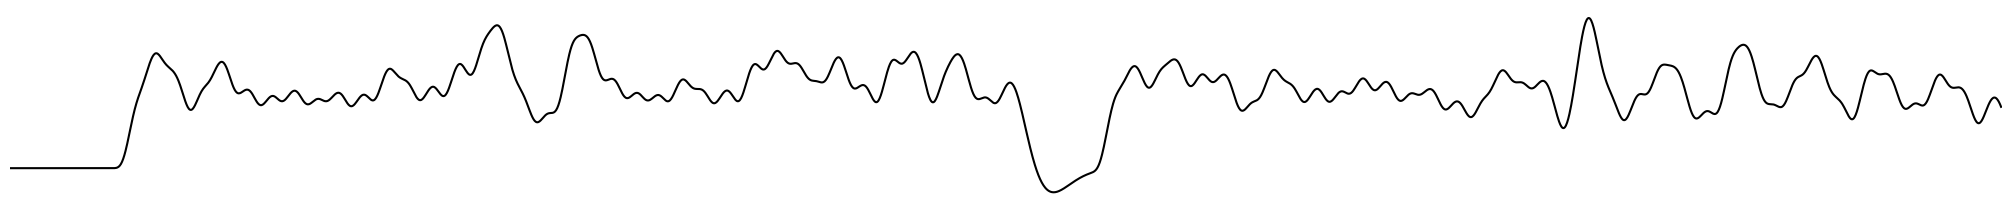

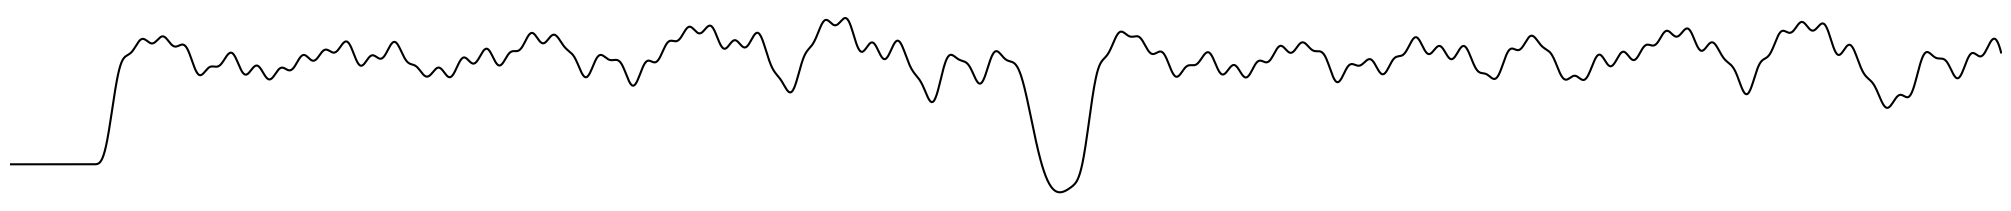

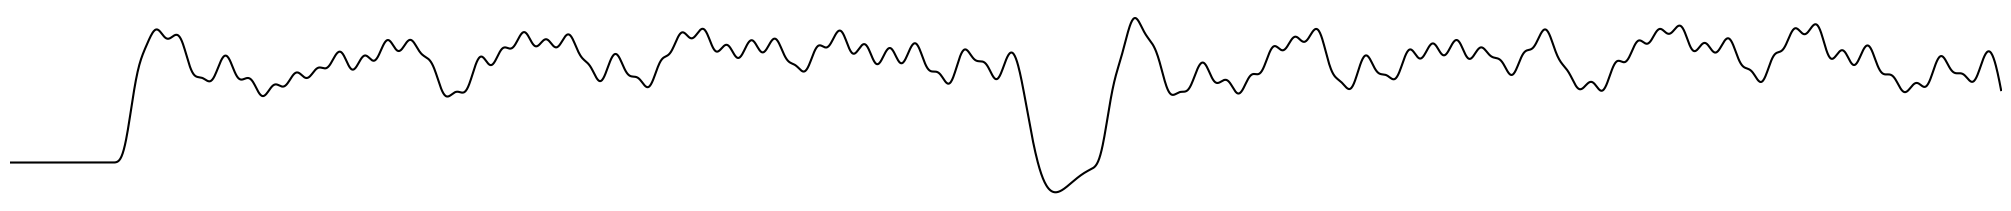

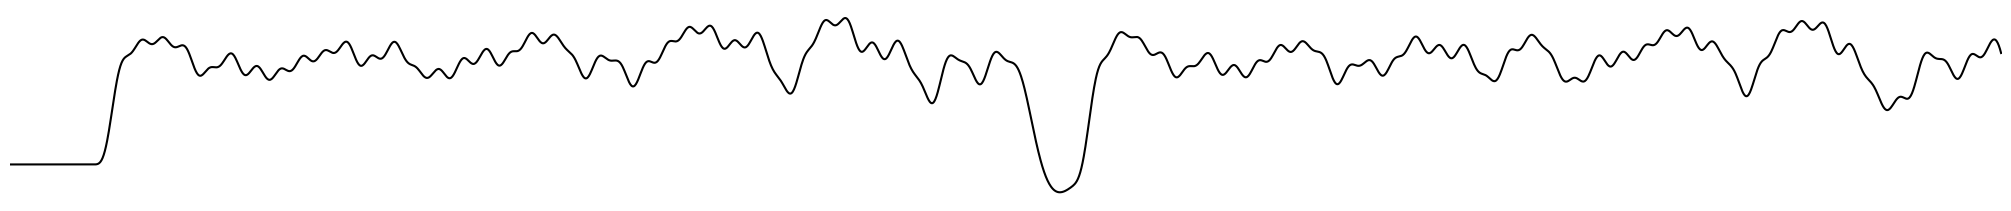

In [44]:
fig, ax1 = plt.subplots(figsize = (20, 2), constrained_layout=True)
tmp_sub = 8
ax1.spines["left"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.spines["bottom"].set_visible(False)

ax1.plot(behav_hrf_data[:,32,tmp_sub], color = 'k')
ax1.set_xlim([0, behav_hrf_data.shape[0]])
ax1.set_yticks([])
ax1.set_xticks([])

fig, ax2 = plt.subplots(figsize = (20, 2), constrained_layout=True)
ax2.spines["left"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.spines["bottom"].set_visible(False)
ax2.plot(behav_hrf_data[:,35,tmp_sub], color = 'k')
ax2.set_xlim([0, behav_hrf_data.shape[0]])
ax2.set_yticks([])
ax2.set_xticks([])
plt.grid(False)

fig, ax3 = plt.subplots(figsize = (20, 2), constrained_layout=True)
ax3.spines["left"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["top"].set_visible(False)
ax3.spines["bottom"].set_visible(False)
ax3.plot(np.mean(behav_hrf_data[:,32,:], axis = 1), color = 'k')
ax3.set_xlim([0, behav_hrf_data.shape[0]])
ax3.set_yticks([])
ax3.set_xticks([])
plt.grid(False)

fig, ax4 = plt.subplots(figsize = (20, 2), constrained_layout=True)
ax4.spines["left"].set_visible(False)
ax4.spines["right"].set_visible(False)
ax4.spines["top"].set_visible(False)
ax4.spines["bottom"].set_visible(False)
ax4.plot(np.mean(behav_hrf_data[:,35,:], axis = 1), color = 'k')
ax4.set_xlim([0, behav_hrf_data.shape[0]])
ax4.set_yticks([])
ax4.set_xticks([])
plt.grid(False)


In [5]:
vif_variables = pd.DataFrame(index=range(Nsubj), columns=range(behav_hrf_data.shape[1]+1))
for si in range(Nsubj): 
    behav_hrf_data_indi = pd.DataFrame(np.squeeze(behav_hrf_data[:,:,si]))
    behav_hrf_data_indi.columns = signal_hrf_labels
    X = sm.add_constant(behav_hrf_data_indi)
    vif = pd.DataFrame()
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif_variables.loc[si] = vif['VIF']

vif_variables.columns = X.columns

/APP/enhpc/fsl/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/APP/enhpc/fsl/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/APP/enhpc/fsl/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/APP/enhpc/fsl/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/APP/enhpc/fsl/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/APP/enhpc/fsl/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:198: Runtim

/home/dayoung/dFC/RL/tools/isc_standalone.py:1840: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator


ISC values shape = (54, 16) 
i.e., 54 left-out subjects and 16 signal(s)
Minimum ISC = nan; maximum ISC = nan


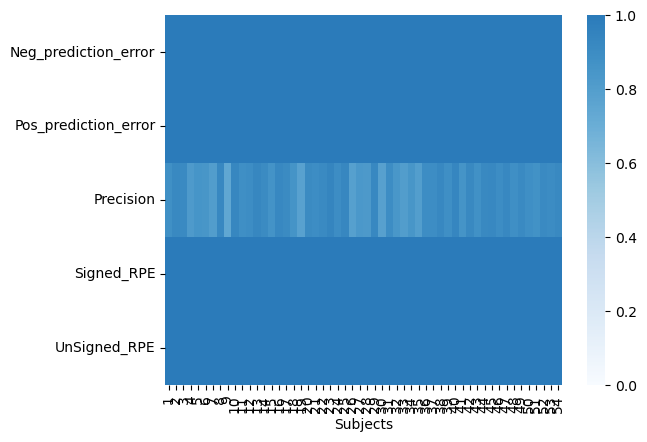

In [6]:
# Leave-one-out approach
behav_iscs_loo = isc(behav_hrf_data, pairwise=False)
# Check shape of output ISC values
print(f"ISC values shape = {behav_iscs_loo.shape} \ni.e., {behav_iscs_loo.shape[0]} "
      f"left-out subjects and {behav_iscs_loo.shape[1]} signal(s)"
      f"\nMinimum ISC = {np.amin(behav_iscs_loo):.3f}; "
      f"maximum ISC = {np.amax(behav_iscs_loo):.3f}")
# Visualize the correlation matrix for each behav_signal
plt.plot(figsize=(30,8))
sns.heatmap(behav_iscs_loo[:,0:5].T, center = 0.7, cmap = "Blues", vmin=0, vmax=1, 
            yticklabels=signal_labels[0:5], xticklabels=range(1, Nsubj+1))
#plt.xlabel('Signals')
plt.xlabel('Subjects')
plt.show()

##### dynamical ISC of behavioral signals

In [ ]:
window_len = 21
window_len_beh = int(window_len*TR*10)
behav_window_iscs_loo = np.empty([Nsubj, behav_hrf_data.shape[1], 1])
for ti in range(int(tp*TR*10) - window_len_beh):
    print(ti)
    window_data = behav_hrf_data[ti:(ti + window_len_beh),...]  # [time, signals, Nsubj]
    tmp_behav_window_iscs_loo = isc(window_data, pairwise=False)  # [54(Nsubj) x 147(Nnodes)]
    tmp_behav_window_iscs_loo = np.expand_dims(tmp_behav_window_iscs_loo, axis = 2)  # [54(Nsubj) x 147(Nnodes) x 1]
    behav_window_iscs_loo = np.concatenate([behav_window_iscs_loo, tmp_behav_window_iscs_loo], axis = 2)

behav_window_iscs_loo = behav_window_iscs_loo[:,:,1:]
print(np.shape(behav_window_iscs_loo))  # [54(Nsubj) x 10(signals_hrf) x 210(tp-window_len)]
np.nan_to_num(behav_window_iscs_loo, copy=False)

np.savez(os.path.join(root_path + 'data','behav','dISC_signal_data.npz'), dISC_signal = behav_window_iscs_loo, signal_hrf_labels = signal_hrf_labels)

In [45]:
if os.path.exists(os.path.join(root_path, "data", "behav", "dISC_signal_data.npz")):
    tmp = np.load(os.path.join(root_path, "data", "behav", "dISC_signal_data.npz"))
    dISC_signal = tmp['dISC_signal']

from matplotlib.backends.backend_pdf import PdfPages

window_len = 21
x_window = np.linspace(0, int(tp-window_len-1), int(tp-window_len))
xq_window = np.linspace(x_window.min(), x_window.max(), int((tp-window_len) * TR * 10))
#plot_y = np.mean(dISC_signal, axis = 0).T
plot_y = dISC_signal[9, :, :].squeeze().T  # (3150, 16)  # put subject index you want to see. 

def rescale(x):#rescale regressors from -1 to 1 for 3d array  
    for regi in range(np.shape(x)[1]):
        tmp_x = x[:,regi]
        tmin=np.min(tmp_x)
        tmax=np.max(tmp_x)
        trange=tmax-tmin
        tmid=tmin+trange/2
        tmp_x=(tmp_x-tmid)/(trange/2)
        x[:,regi] = tmp_x
    return x


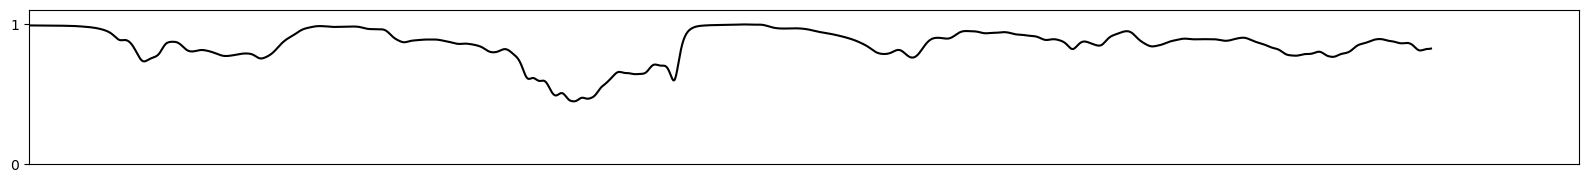

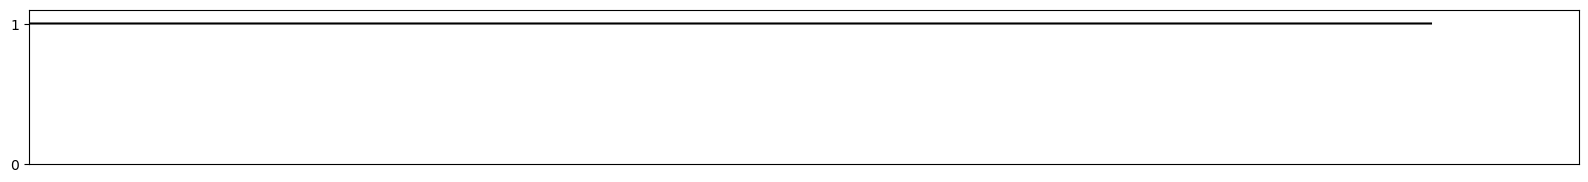

In [53]:

# individual precision action dISC plot
fig, ax = plt.subplots(figsize=(20,2))
ax.plot(xq_window, plot_y[:,2], color = 'k')

ax.set_xlim([0, tp])
ax.set_yticks([0, 1])
ax.set_xticks([])
ax.set_ylim([0, 1.1])
ax.grid(False)

fig, ax = plt.subplots(figsize=(20,2))
ax.plot(xq_window, plot_y[:,4], color = 'k')

ax.set_xlim([0, tp])
ax.set_yticks([0, 1])
ax.set_ylim([0, 1.1])
ax.set_xticks([])
ax.grid(False)

In [ ]:

plt.figure(figsize=(20,8))
plt.plot(xq_window, plot_y[:,[2, 4, 5, 8, 9]])
labels = [signal_labels[i] for i in [2, 4, 5, 8, 9]]
plt.legend(labels, loc = 'lower right')
plt.title('Average dISC of behavioral signal')
plt.axvline(x=xq_window[int(7*TR*10 + 10 - 1)], color='k', linestyle='--', linewidth=3)
plt.axvline(x=xq_window[int(114*TR*10 + 5 - 1)], color='k', linestyle='--', linewidth=3)
plt.axvline(x=xq_window[int(121*TR*10 - 1)], color='k', linestyle='--', linewidth=3)
# plt.axvline(x=xq_window[int(227*TR*10 + 10 - 1)], color='k', linestyle='--', linewidth=3)
plt.grid(True)
plt.xlim([0, tp])

## plot for fig. 4b
fig = plt.figure(figsize=(20,4))
plt.plot(xq_window, plot_y[:,[2, 4, 9]])
plt.legend([signal_labels[i] for i in [2, 4, 9]], loc = 'lower right', fontsize = 16)
plt.axvline(x=xq_window[int(7*TR*10 + 10 - 1)], color='k', linestyle='--', linewidth=1)
plt.fill_between([0, xq_window[int(7*TR*10 + 10 - 1)]], [1.1, 1.1], color = 'k', alpha = 0.1)
plt.axvline(x=xq_window[int(121*TR*10 - 1)], color='k', linestyle='--', linewidth=1)
#plt.fill_between([xq_window[int(121*TR*10 - 1)] - window_len, xq_window[int(121*TR*10 - 1)] + window_len], [1.1, 1.1], color = 'k', alpha = 0.1)
plt.fill_between([xq_window[int(121*TR*10 - 1)] - window_len*TR, xq_window[int(121*TR*10 - 1)]], [1.1, 1.1], color = 'k', alpha = 0.1)
#plt.ylim([0.3, 1.05])
plt.xlim([0, tp])
plt.show()
plt.grid(False)

pdf_file_path = os.path.join(root_path,'results','Figures','fig4c.pdf')
with PdfPages(pdf_file_path) as pdf:
    pdf.savefig(fig)

min_max_scaler = MinMaxScaler()
plot_y = min_max_scaler.fit_transform((plot_y[:,0:5]))

plt.figure(figsize=(20,8))
plt.plot(xq_window, plot_y)
plt.legend(labels, loc = 'lower right')
plt.title('Average dISC of behavioral signal')
plt.axvline(x=xq_window[int(7*TR*10 + 10 - 1)], color='k', linestyle='--', linewidth=3)
plt.axvline(x=xq_window[int(114*TR*10 + 5 - 1)], color='k', linestyle='--', linewidth=3)
plt.axvline(x=xq_window[int(121*TR*10 - 1)], color='k', linestyle='--', linewidth=3)
# plt.axvline(x=xq_window[int(227*TR*10 + 10 - 1)], color='k', linestyle='--', linewidth=3)
plt.grid(True)
plt.xlim([0, tp])


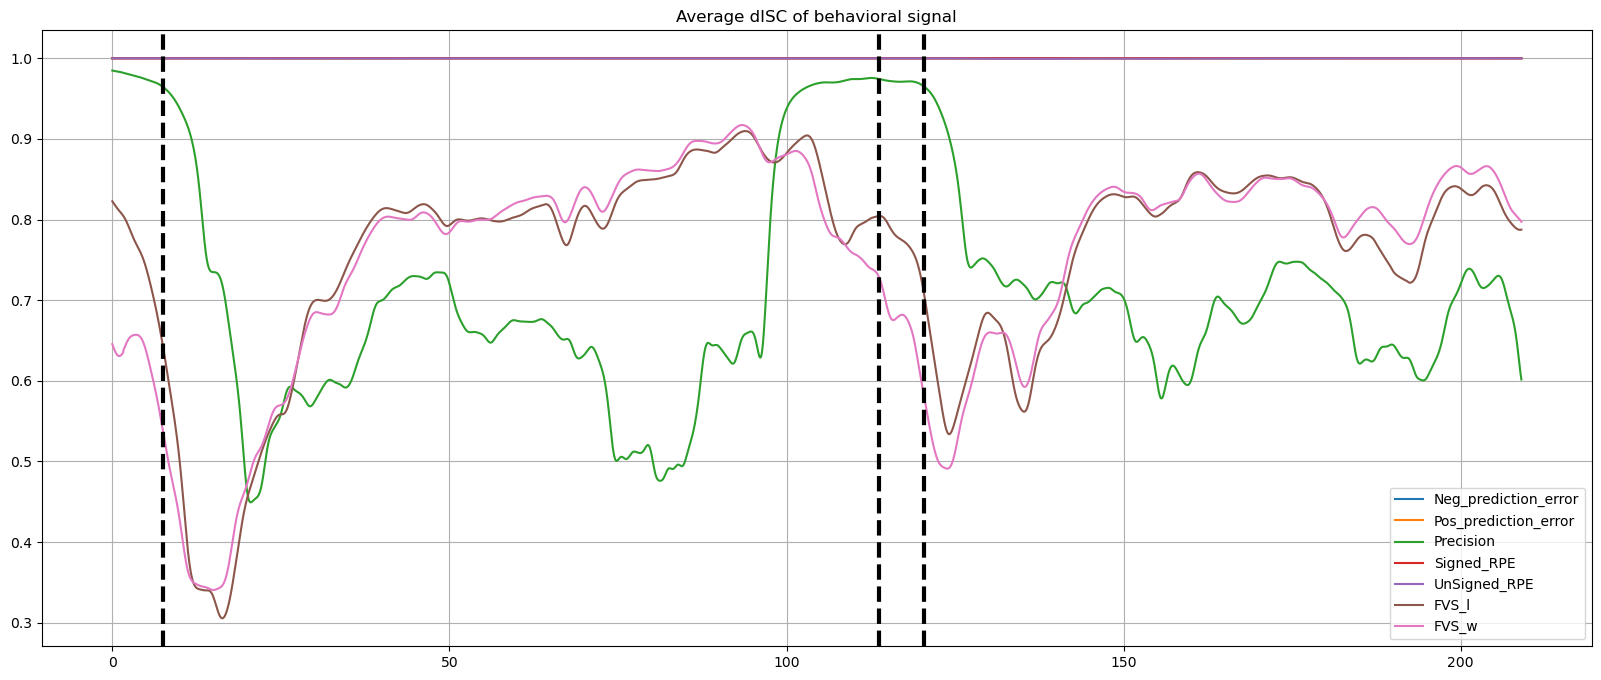

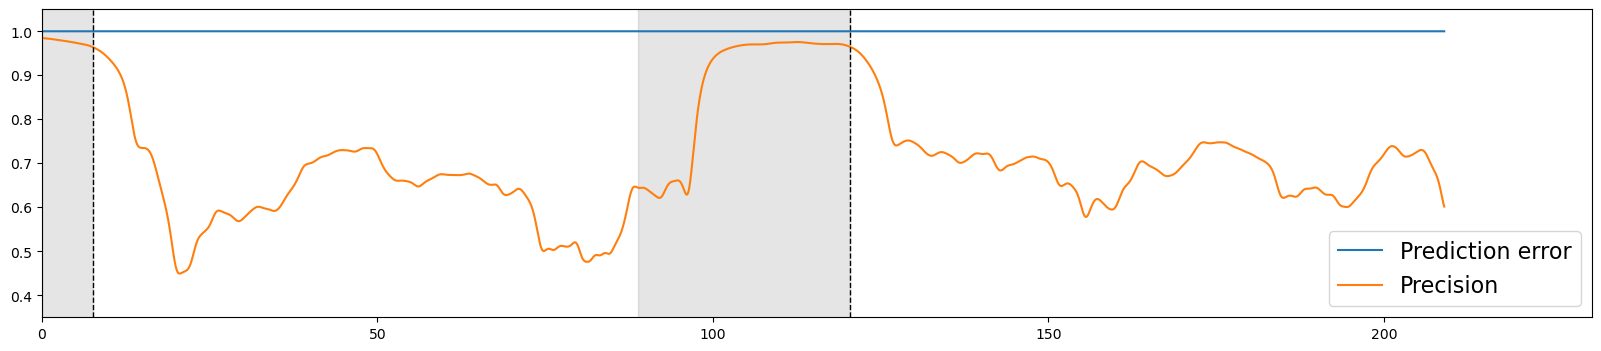

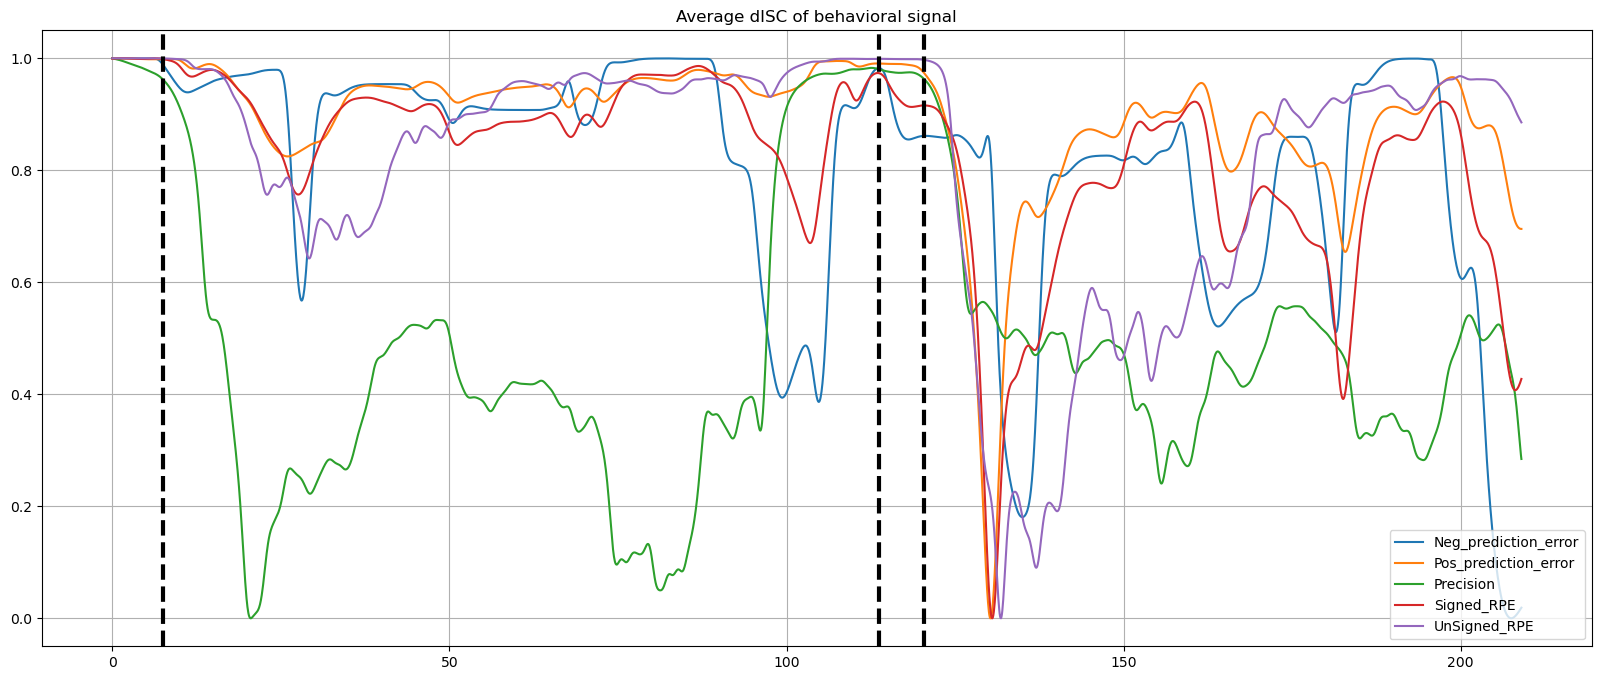

In [14]:
if os.path.exists(os.path.join(root_path, "data", "behav", "dISC_signal_data.npz")):
    tmp = np.load(os.path.join(root_path, "data", "behav", "dISC_signal_data.npz"))
    dISC_signal = tmp['dISC_signal']
from matplotlib.backends.backend_pdf import PdfPages

window_len = 21
x_window = np.linspace(0, int(tp-window_len-1), int(tp-window_len))
xq_window = np.linspace(x_window.min(), x_window.max(), int((tp-window_len) * TR * 10))
plot_y = np.mean(dISC_signal, axis = 0).T
def rescale(x):#rescale regressors from -1 to 1 for 3d array  
    for regi in range(np.shape(x)[1]):
        tmp_x = x[:,regi]
        tmin=np.min(tmp_x)
        tmax=np.max(tmp_x)
        trange=tmax-tmin
        tmid=tmin+trange/2
        tmp_x=(tmp_x-tmid)/(trange/2)
        x[:,regi] = tmp_x
    return x

plt.figure(figsize=(20,8))
plt.plot(xq_window, np.hstack([plot_y[:,0:5], plot_y[:,8:10]]))
labels = signal_labels[0:5] + signal_labels[8:10]
plt.legend(labels, loc = 'lower right')
plt.title('Average dISC of behavioral signal')
plt.axvline(x=xq_window[int(7*TR*10 + 10 - 1)], color='k', linestyle='--', linewidth=3)
plt.axvline(x=xq_window[int(114*TR*10 + 5 - 1)], color='k', linestyle='--', linewidth=3)
plt.axvline(x=xq_window[int(121*TR*10 - 1)], color='k', linestyle='--', linewidth=3)
# plt.axvline(x=xq_window[int(227*TR*10 + 10 - 1)], color='k', linestyle='--', linewidth=3)
plt.grid(True)
plt.xlim([0, tp])

## plot for fig. 4b
fig = plt.figure(figsize=(20,4))
plt.plot(xq_window, plot_y[:,1:3])
plt.legend(['Prediction error', 'Precision'], loc = 'lower right', fontsize = 16)
plt.axvline(x=xq_window[int(7*TR*10 + 10 - 1)], color='k', linestyle='--', linewidth=1)
plt.fill_between([0, xq_window[int(7*TR*10 + 10 - 1)]], [1.1, 1.1], color = 'k', alpha = 0.1)
plt.axvline(x=xq_window[int(121*TR*10 - 1)], color='k', linestyle='--', linewidth=1)
#plt.fill_between([xq_window[int(121*TR*10 - 1)] - window_len, xq_window[int(121*TR*10 - 1)] + window_len], [1.1, 1.1], color = 'k', alpha = 0.1)
plt.fill_between([xq_window[int(121*TR*10 - 1)] - window_len*TR, xq_window[int(121*TR*10 - 1)]], [1.1, 1.1], color = 'k', alpha = 0.1)
plt.ylim([0.35, 1.05])
plt.xlim([0, tp])

plt.grid(False)
'''
pdf_file_path = os.path.join(root_path,'results','Figures','fig4c.pdf')
with PdfPages(pdf_file_path) as pdf:
    pdf.savefig(fig)
'''
min_max_scaler = MinMaxScaler()
plot_y = min_max_scaler.fit_transform((plot_y[:,0:5]))

plt.figure(figsize=(20,8))
plt.plot(xq_window, plot_y)
plt.legend(labels, loc = 'lower right')
plt.title('Average dISC of behavioral signal')
plt.axvline(x=xq_window[int(7*TR*10 + 10 - 1)], color='k', linestyle='--', linewidth=3)
plt.axvline(x=xq_window[int(114*TR*10 + 5 - 1)], color='k', linestyle='--', linewidth=3)
plt.axvline(x=xq_window[int(121*TR*10 - 1)], color='k', linestyle='--', linewidth=3)
# plt.axvline(x=xq_window[int(227*TR*10 + 10 - 1)], color='k', linestyle='--', linewidth=3)
plt.grid(True)
plt.xlim([0, tp])


#### dynamical ISC of edge connetivity

In [10]:
window_len = 21
Nedges = int(Nnodes*(Nnodes-1)/2)
window_isfcs_loo = np.empty([Nsubj, Nedges, 1])
for ti in range(tp - window_len):
    window_data = neuro_data[ti:(ti + window_len),...]
    tmp_window_isfcs_loo = isfc(window_data, pairwise=False, vectorize_isfcs=True)  # tuple whose [0] is (Nsubj x Nedges) and [1] i (Nsubj x Nnodes)
    tmp_window_isfcs_loo = np.asarray(tmp_window_isfcs_loo[0])  # [54(Nsubj) x 10731(Nedges)]
    tmp_window_isfcs_loo = np.expand_dims(tmp_window_isfcs_loo, axis = 2)  # [54(Nsubj) x 10731(Nedges) x 1]
    window_isfcs_loo = np.concatenate([window_isfcs_loo, tmp_window_isfcs_loo], axis = 2)

window_isfcs_loo = window_isfcs_loo[:,:,1:]
print(np.shape(window_isfcs_loo))  # [54(Nsubj) x 10731(Nedges) x 210(tp-window_len)]

x = np.linspace(0, int(tp-window_len-1), int(tp-window_len))
xq = np.linspace(x.min(), x.max(), int((tp-window_len) * TR * 10))
window_isfcs_loo = np.swapaxes(window_isfcs_loo, 0, 2)  
print(np.shape(window_isfcs_loo)) # [210(tp-window_len) x 10731(Nedges) x 54(Nsubj) ]
tmp = interp1d(x, window_isfcs_loo, kind = 'quadratic', axis = 0)
window_isfcs_loo_interpd = tmp(xq)

neuro_con_data_whole = mat73.loadmat(os.path.join(root_path, "results", "leida", "Leida_eig.mat"))
Leading_Eig = neuro_con_data_whole['Leading_Eig']
print(np.shape(Leading_Eig))
LE_bold_all = np.reshape(Leading_Eig, [Nsubj, tp, Nnodes])
del Leading_Eig

mask = np.triu(np.ones((Nnodes, Nnodes), dtype=bool), k=1)
i_mask = np.where(mask)

neuro_con_data = np.zeros([Nsubj, tp, Nedges])
for si in range(Nsubj):
    data = np.squeeze(LE_bold_all[si,:,:])
    for ti in range(tp):
        FC = np.dot(np.expand_dims(data[ti,:], axis = 1),np.expand_dims(data[ti,:], axis = 0))
        FC = np.nan_to_num(FC, copy=False)
        neuro_con_data[si,ti,:] = FC[i_mask[0],i_mask[1]]

neuro_con_data = np.moveaxis(neuro_con_data, 0, 2)  # [tp x Nedges x Nsubj]
neuro_con_data.shape

(54, 10731, 210)
(210, 10731, 54)
(12474, 147)


(231, 10731, 54)

In [ ]:
# This part takes long time
con_window_isfcs_loo = np.empty([Nsubj, Nedges, 1])
for ti in range(tp - window_len):
    window_data = neuro_con_data[ti:(ti + window_len),...]
    tmp_window_isfcs_loo = isc(window_data, pairwise=False)  # tuple whose [0] is (Nsubj x Nedges) and [1] i (Nsubj x Nnodes)
    #tmp_window_isfcs_loo = np.asarray(tmp_window_isfcs_loo[0])  # [54(Nsubj) x 10731(Nedges)]
    tmp_window_isfcs_loo = np.expand_dims(tmp_window_isfcs_loo, axis = 2)  # [54(Nsubj) x 10731(Nedges) x 1]
    con_window_isfcs_loo = np.concatenate([con_window_isfcs_loo, tmp_window_isfcs_loo], axis = 2)

con_window_isfcs_loo = con_window_isfcs_loo[:,:,1:]
print(np.shape(con_window_isfcs_loo))  # [54(Nsubj) x 10731(Nedges) x 210(tp-window_len)]

x = np.linspace(0, int(tp-window_len-1), int(tp-window_len))
xq = np.linspace(x.min(), x.max(), int((tp-window_len) * TR * 10))
con_window_isfcs_loo = np.swapaxes(con_window_isfcs_loo, 0, 2)  
print(con_window_isfcs_loo.shape) # [210(tp-window_len) x 10731(Nedges) x 54(Nsubj) ]
tmp = interp1d(x, con_window_isfcs_loo, kind = 'quadratic', axis = 0)
con_window_isfcs_loo_interpd = tmp(xq)

os.chdir(os.path.join(root_path, 'results'))
try:
    if not os.path.exists('isc'):
        os.makedirs('isc')
except OSError:
    print("Error: Failed to create the directory.")
np.savez(os.path.join(root_path, 'results', 'isc', 'dISFC.npz'), con_window_isfcs_loo=con_window_isfcs_loo, con_window_isfcs_loo_interpd=con_window_isfcs_loo_interpd)

In [ ]:
plt.figure(figsize=(20, 8))
plt.subplot(2,1,1)
plt.plot(xq, np.squeeze(np.mean(con_window_isfcs_loo_interpd,2)))
plt.subplot(2,1,2)
plt.plot(xq, np.squeeze(np.mean(window_isfcs_loo_interpd,2)))
plt.tight_layout()
plt.show()